In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import candas as can
import gumbi as gmb
from candas.test import FluorescenceData, QuantStudio

import pathlib as pl
code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.futura))

%config InlineBackend.figure_format = 'retina'

In [2]:
fig_num = 'ED1'

panel = None
subpanel = None

def savefig(fig=None, title=None):
    fig = fig or plt.gcf()
    title = title or 'Fig_'+'_'.join([str(el) for el in [fig_num, panel, subpanel] if el is not None])
    print(f'Saving {title} in {graph_pth}:', end='')
    for ext in ['svg', 'png']:
        try:
            fig.savefig(graph_pth / f'{title}.{ext}', dpi=600, transparent=True)
            print(f' [.{ext}]', end='')
        except AttributeError:
            print(f' [.{ext} failed]', end='')
    print(' done')

In [3]:
cmax = 50

JG075B = (
    QuantStudio(data_pth / 'JG075B L-MMMMx blocker tripartite competition separate.xlsx', 'JG075B')
    .import_data()
    .format_reactions()
    .index_reactions()
    .subtract_background()
    .normalize_reactions(cmax=cmax)
    .invert_fluorophore('FAM')
)

# Denote reaction conditions
JG075B.reactions.wide = (
    JG075B.reactions.wide
    .replace(
        {'Target': {
            'S075_WTFAM': 'S075_WT',
            'S075_WTHEX': 'S075_WT',
            'S075_SNVFAM': 'S075_SNV',
            'S075_SNVHEX': 'S075_SNV',
        }
        })
    .merge(pd.read_csv(data_pth / 'JG075B Plate Map.csv'))#[['Sample','WT Conc','Competitor Conc','Primer Conc']])
    .assign(lg10_Blocker = lambda df: np.log10(df['Blocker μM']))
    .replace({'lg10_Blocker': {-np.inf: -2}})
    .drop(columns=['CT'])
)


JG075B.reactions.neaten()
JG075B.extract_endpoints(cmax=cmax)
endpoints = JG075B.endpoints
JG075B.reactions

/home/john/projects/CAN_paper/env/can_manuscript/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Experiment,Well,Target,lg10_Copies,Outlier,WellPosition,Copies,Reporter,Sample,Task,Comments,Reaction,Blocker,Blocker μM,Configuration,WellName,lg10_Blocker,Cycle,Fluorescence,Corr_Fluorescence
0,JG075B,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075B_001,STANDARD,,0,L-MMMMx,3.162278,2+2,A1,0.5,1,-0.001097,0.003485
1,JG075B,1,S075_WT,8.0,False,A1,100000000.0,HEX,JG075B_001,STANDARD,,1,L-MMMMx,3.162278,2+2,A1,0.5,1,0.000695,0.001712
2,JG075B,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075B_001,STANDARD,,0,L-MMMMx,3.162278,2+2,A1,0.5,2,-0.000667,0.002776
3,JG075B,1,S075_WT,8.0,False,A1,100000000.0,HEX,JG075B_001,STANDARD,,1,L-MMMMx,3.162278,2+2,A1,0.5,2,0.000553,0.001408
4,JG075B,1,S075_WT,8.0,False,A1,100000000.0,FAM,JG075B_001,STANDARD,,0,L-MMMMx,3.162278,2+2,A1,0.5,3,0.002053,0.000296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44635,JG075B,376,S075_SNV,1.0,False,P16,10.0,HEX,JG075B_376,STANDARD,,495,L-MMMMx,0.000000,7+2,P16,-2.0,88,1.717209,1.278983
44636,JG075B,376,S075_SNV,1.0,False,P16,10.0,FAM,JG075B_376,STANDARD,,494,L-MMMMx,0.000000,7+2,P16,-2.0,89,-0.453918,0.440494
44637,JG075B,376,S075_SNV,1.0,False,P16,10.0,HEX,JG075B_376,STANDARD,,495,L-MMMMx,0.000000,7+2,P16,-2.0,89,1.735487,1.292101
44638,JG075B,376,S075_SNV,1.0,False,P16,10.0,FAM,JG075B_376,STANDARD,,494,L-MMMMx,0.000000,7+2,P16,-2.0,90,-0.458040,0.444762


In [4]:
target_palette = list(zip(['S075_WT','S075_SNV'],['Purples','Greens']))

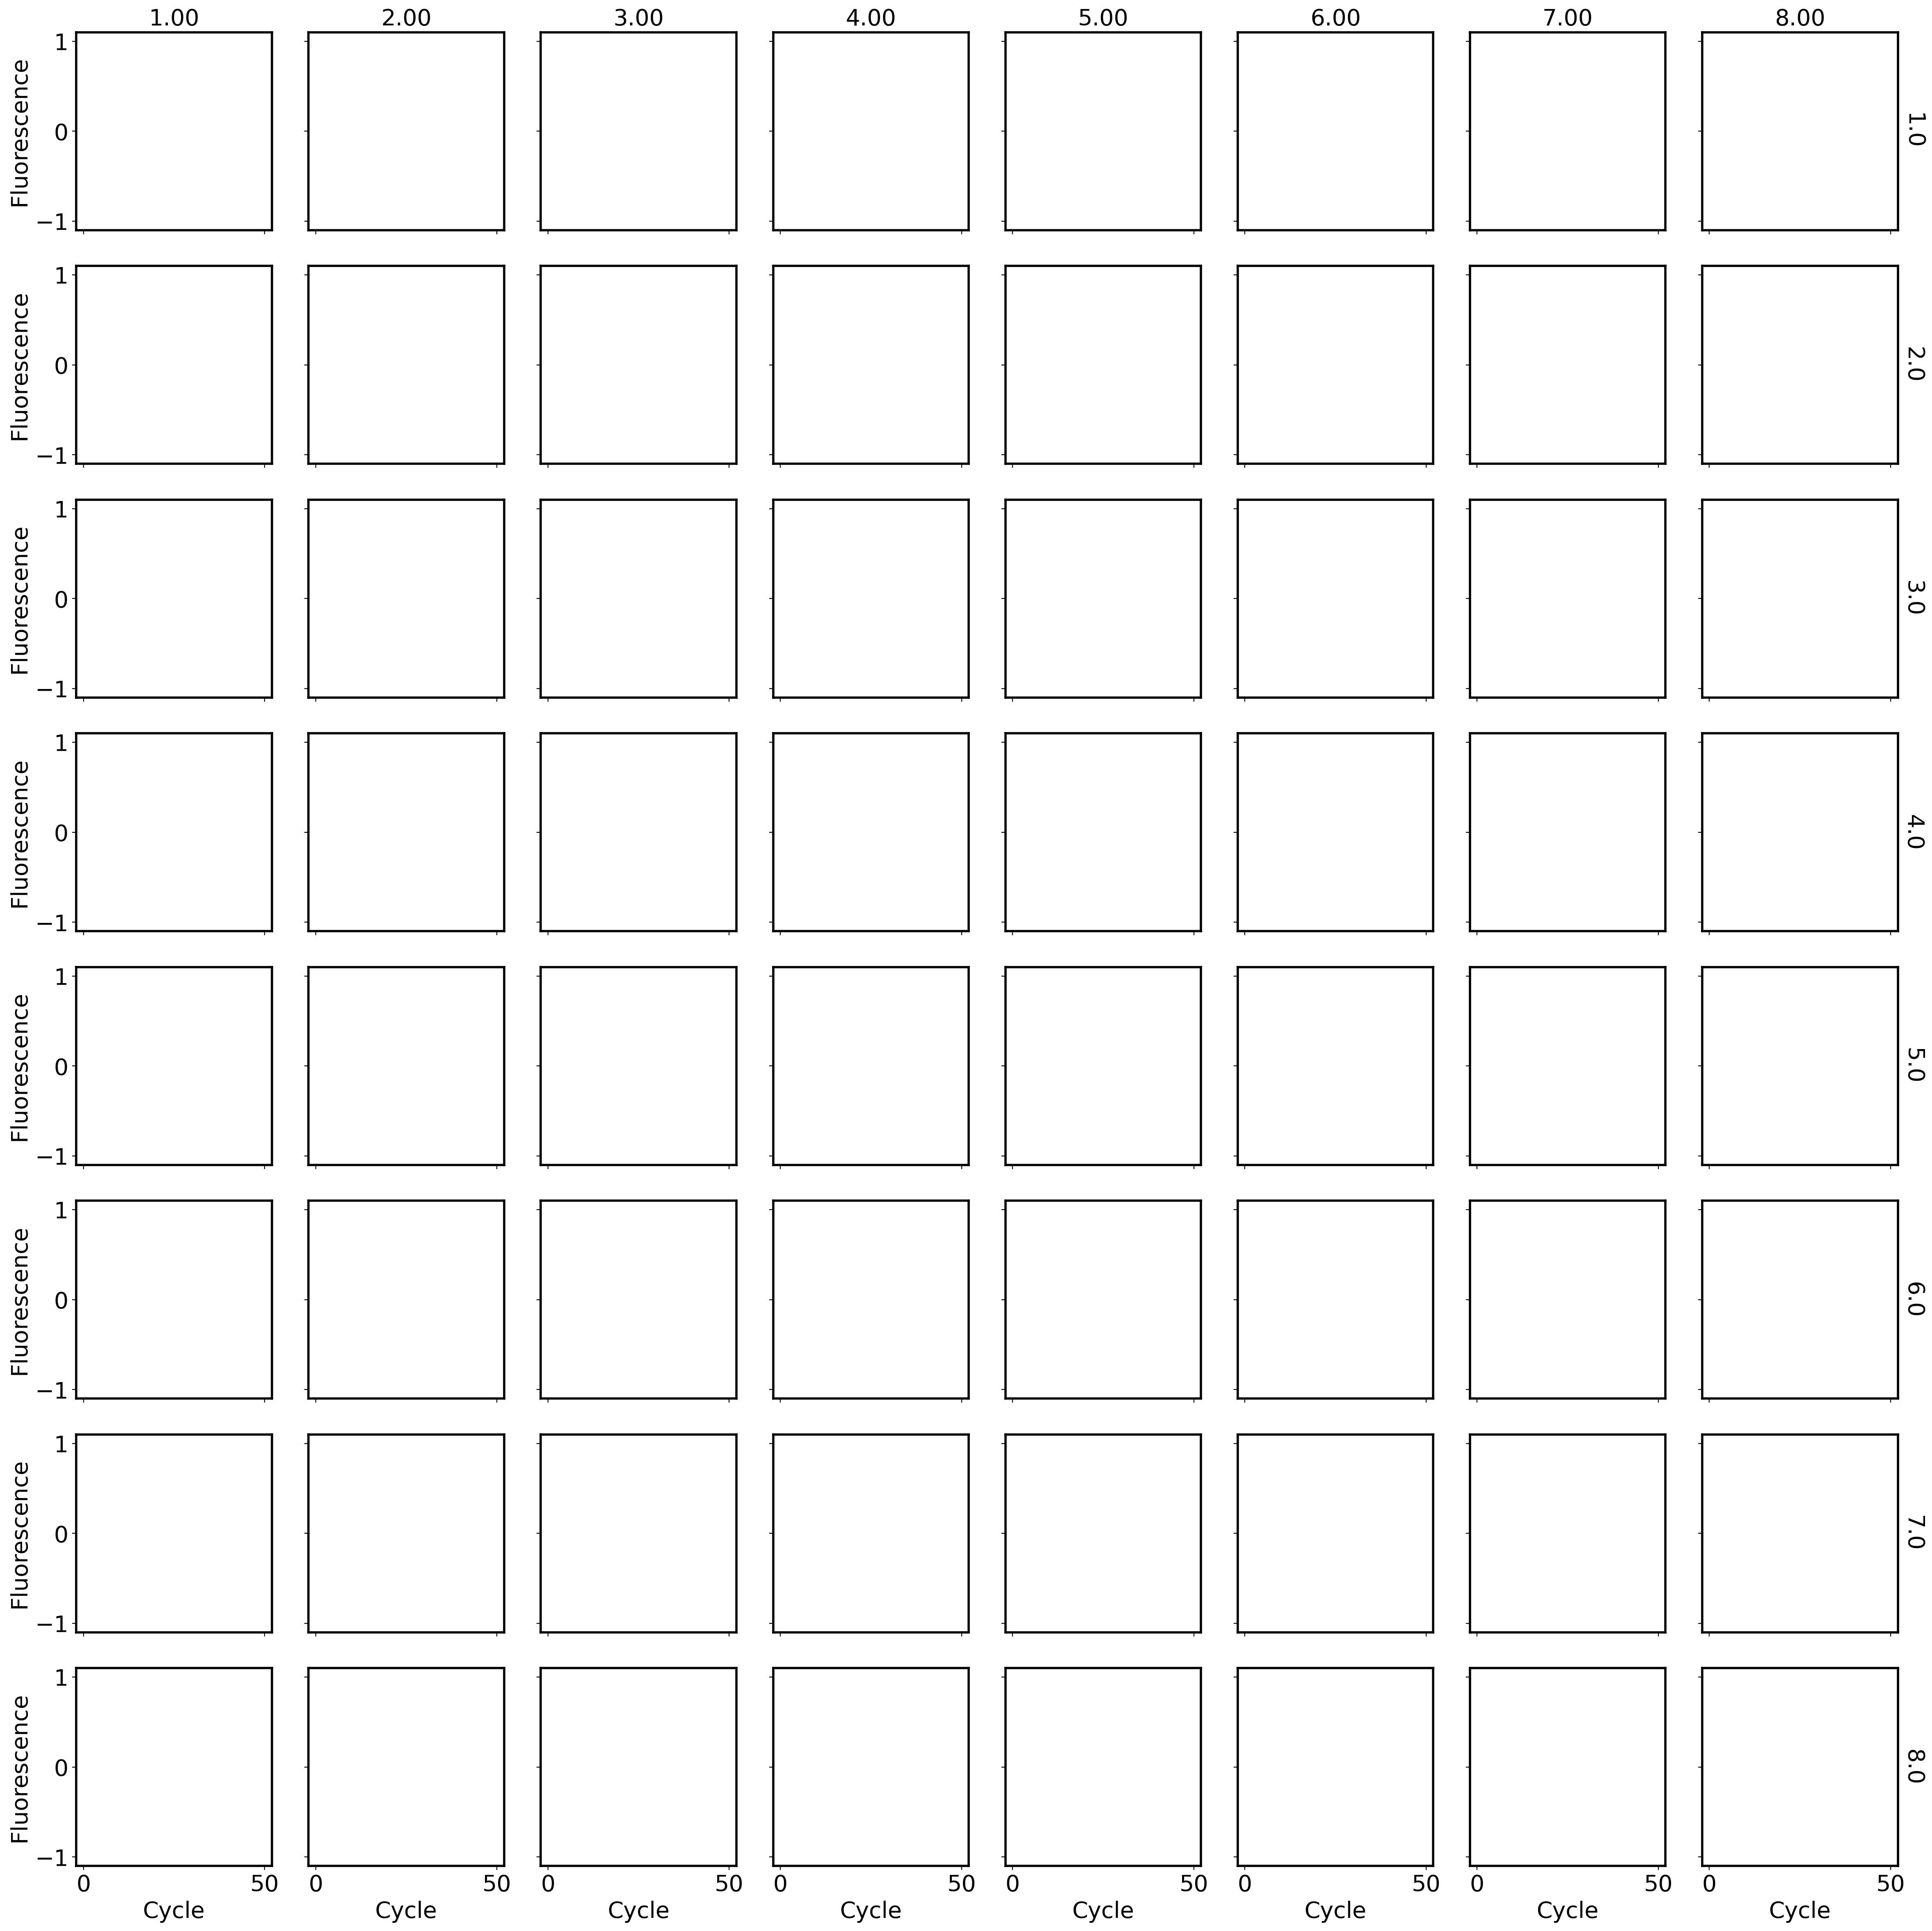

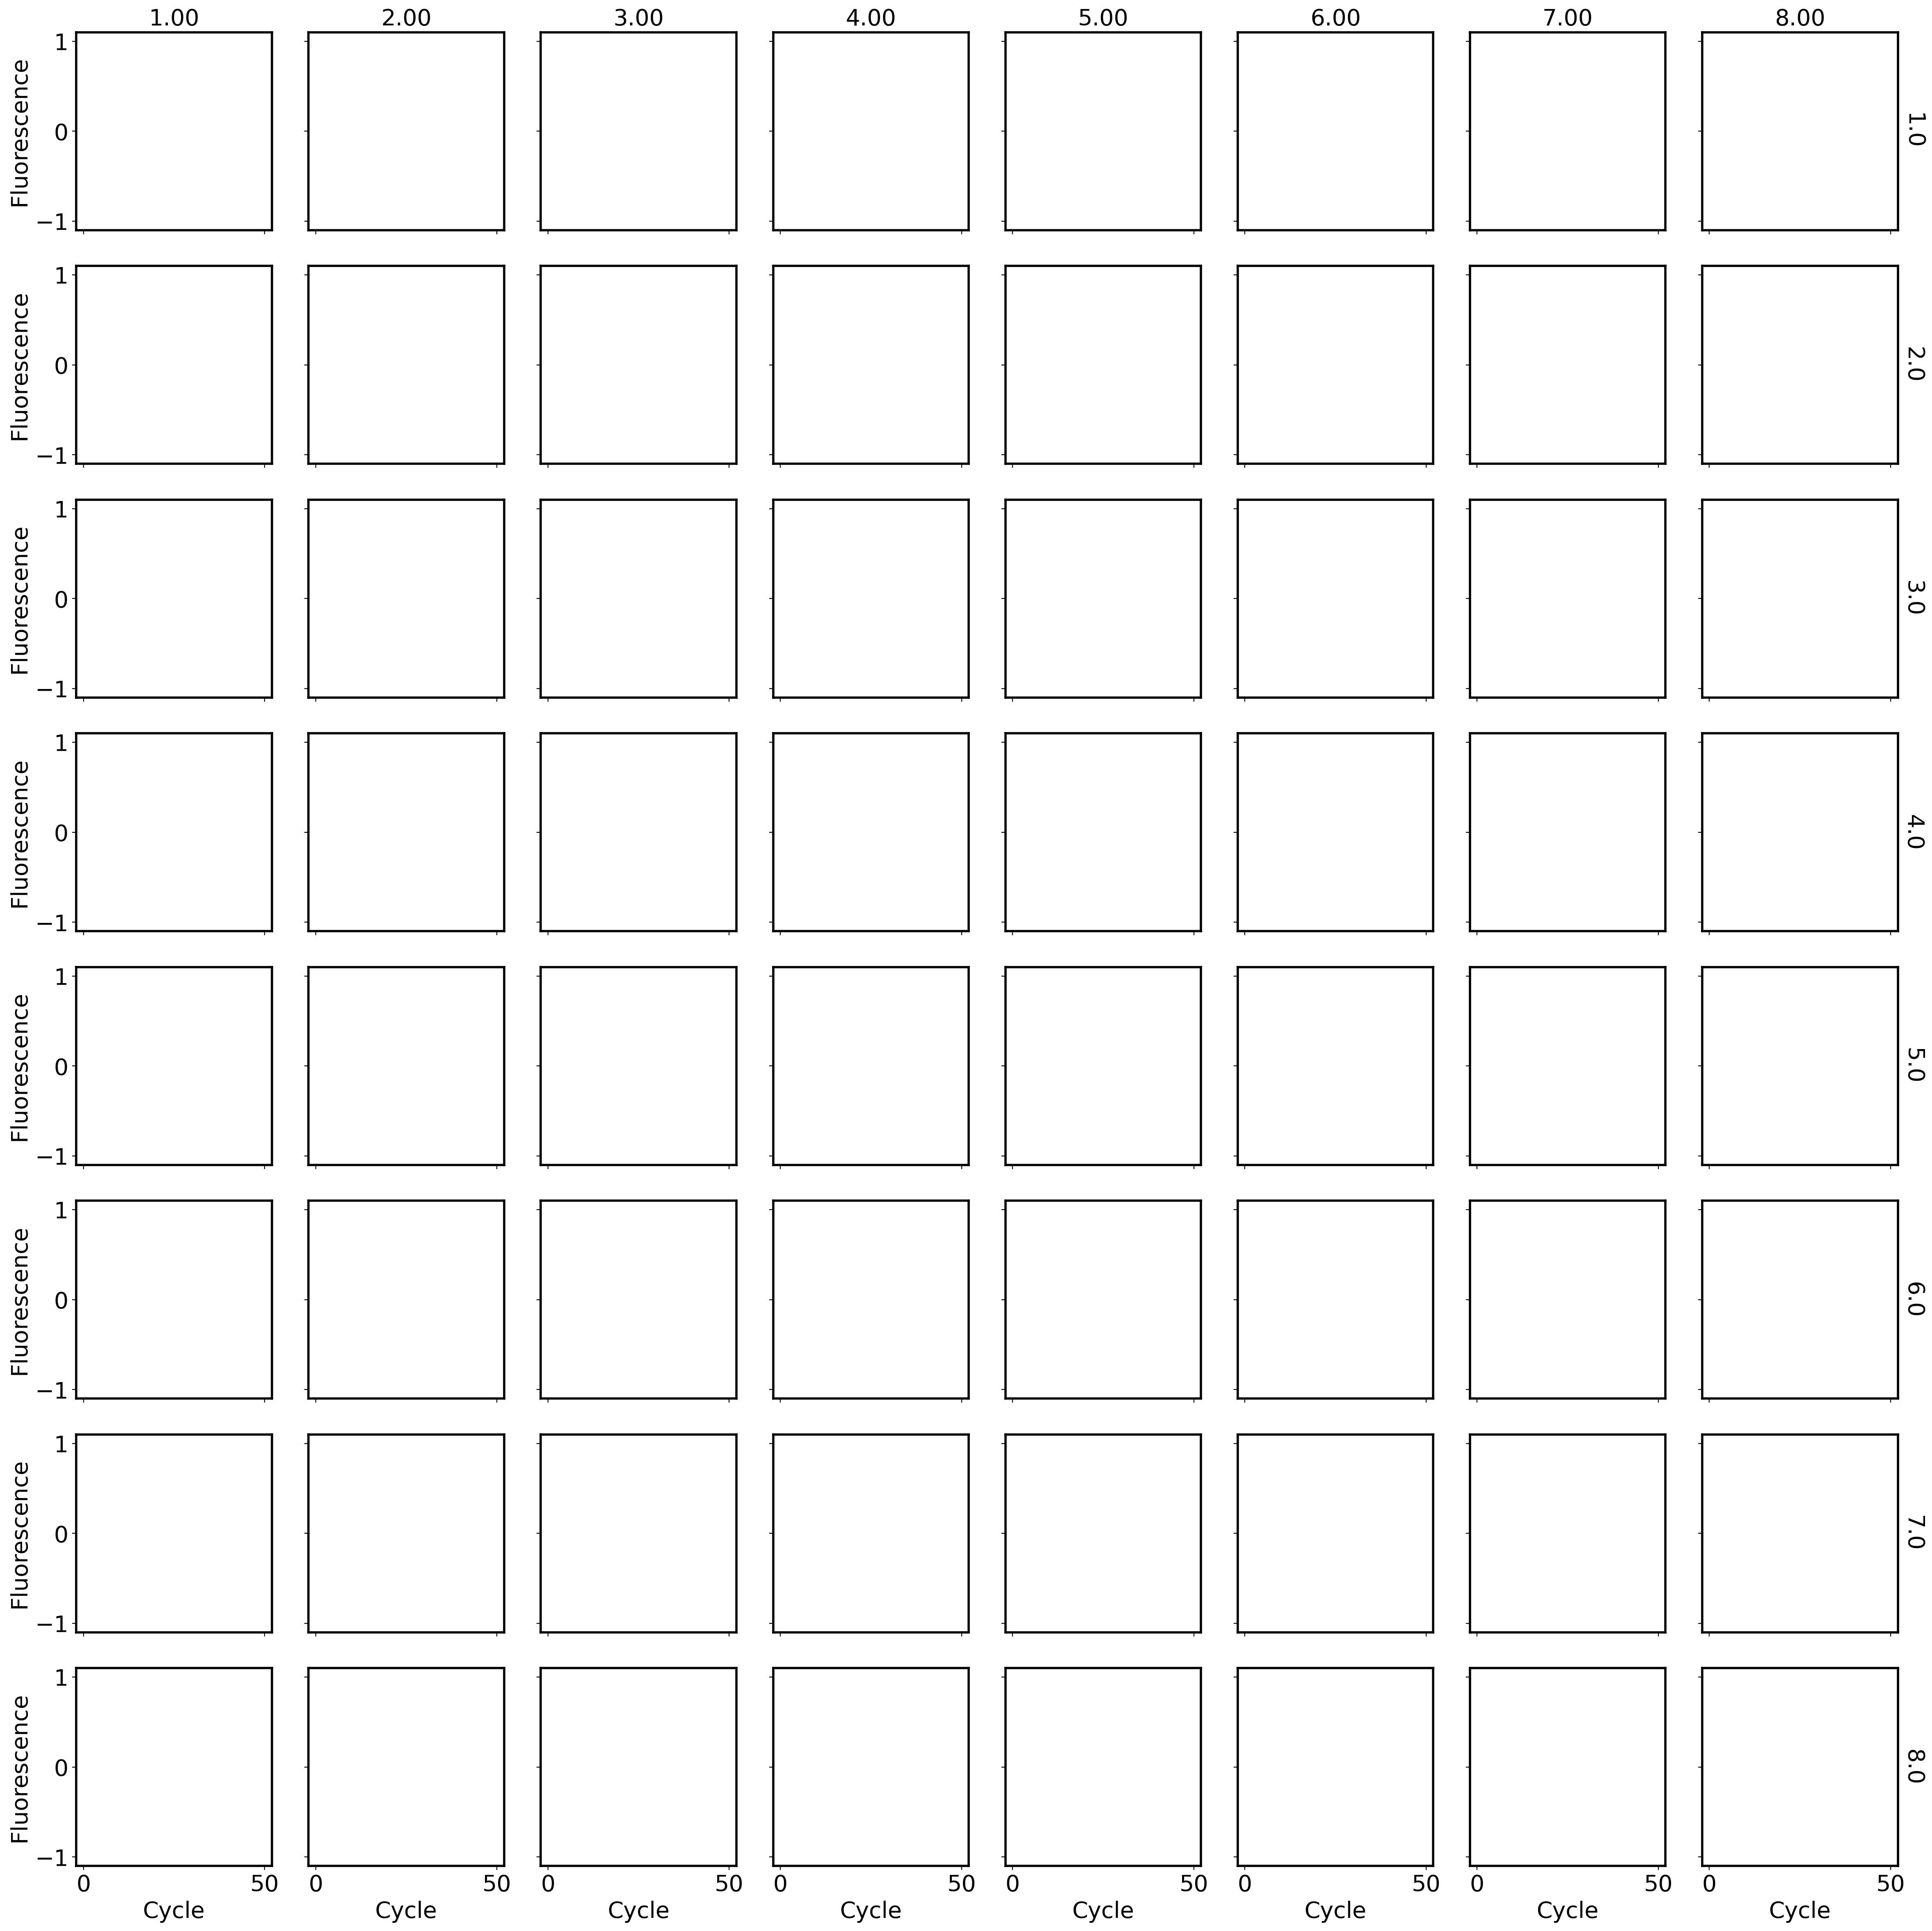

In [5]:
hue = 'lg10_Blocker'
extent = np.max(np.abs(JG075B.reactions.wide[hue]))
norm = mpl.colors.Normalize(vmin=JG075B.reactions.wide[hue].min(), vmax=JG075B.reactions.wide[hue].max())

for target, palette in target_palette:
    data = JG075B.reactions.data
    data = data[
#         (data.Configuration==config) &
        (data.Target==target)
    ]

    g = sns.relplot(data = data,
                    x='Cycle', y='Fluorescence', col='lg10_Copies', row='Configuration', units='Reaction', hue = hue,
                    legend = False, palette=palette, hue_norm=norm, kind='line', estimator=None,
                    height=3, aspect=1.0, linewidth=4,
                    row_order = JG075B.reactions.data['lg10_Copies'].unique()[::-1],
                    facet_kws={
                        'margin_titles': True,
                        'despine': False})

    g.refline(y=0, color='k', linestyle='-')
    g.refline(y=0.1, color='k', linestyle=':')
    g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
    g.set(ylim=[-1.1, 1.1], xlim=[-2, cmax+2])
    # g.set_titles(col_template="", row_template="")
    plt.tight_layout();

#     can.utils.savefig(f'JG075B Amplification curves by configuration - {target}', path=fig_pth)

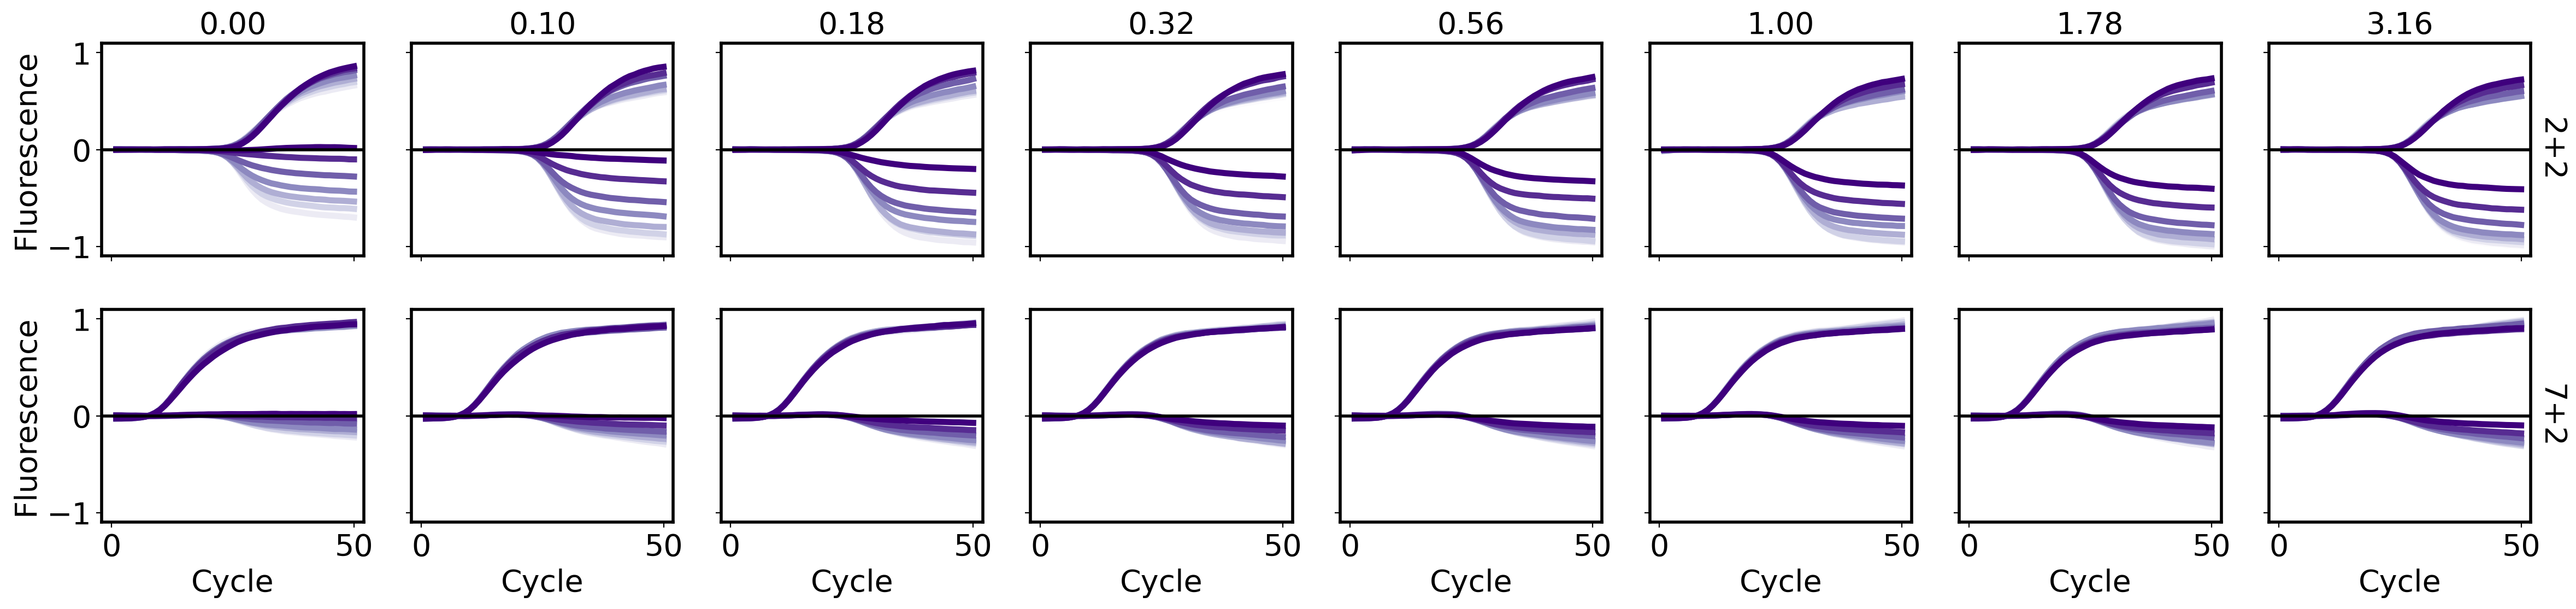

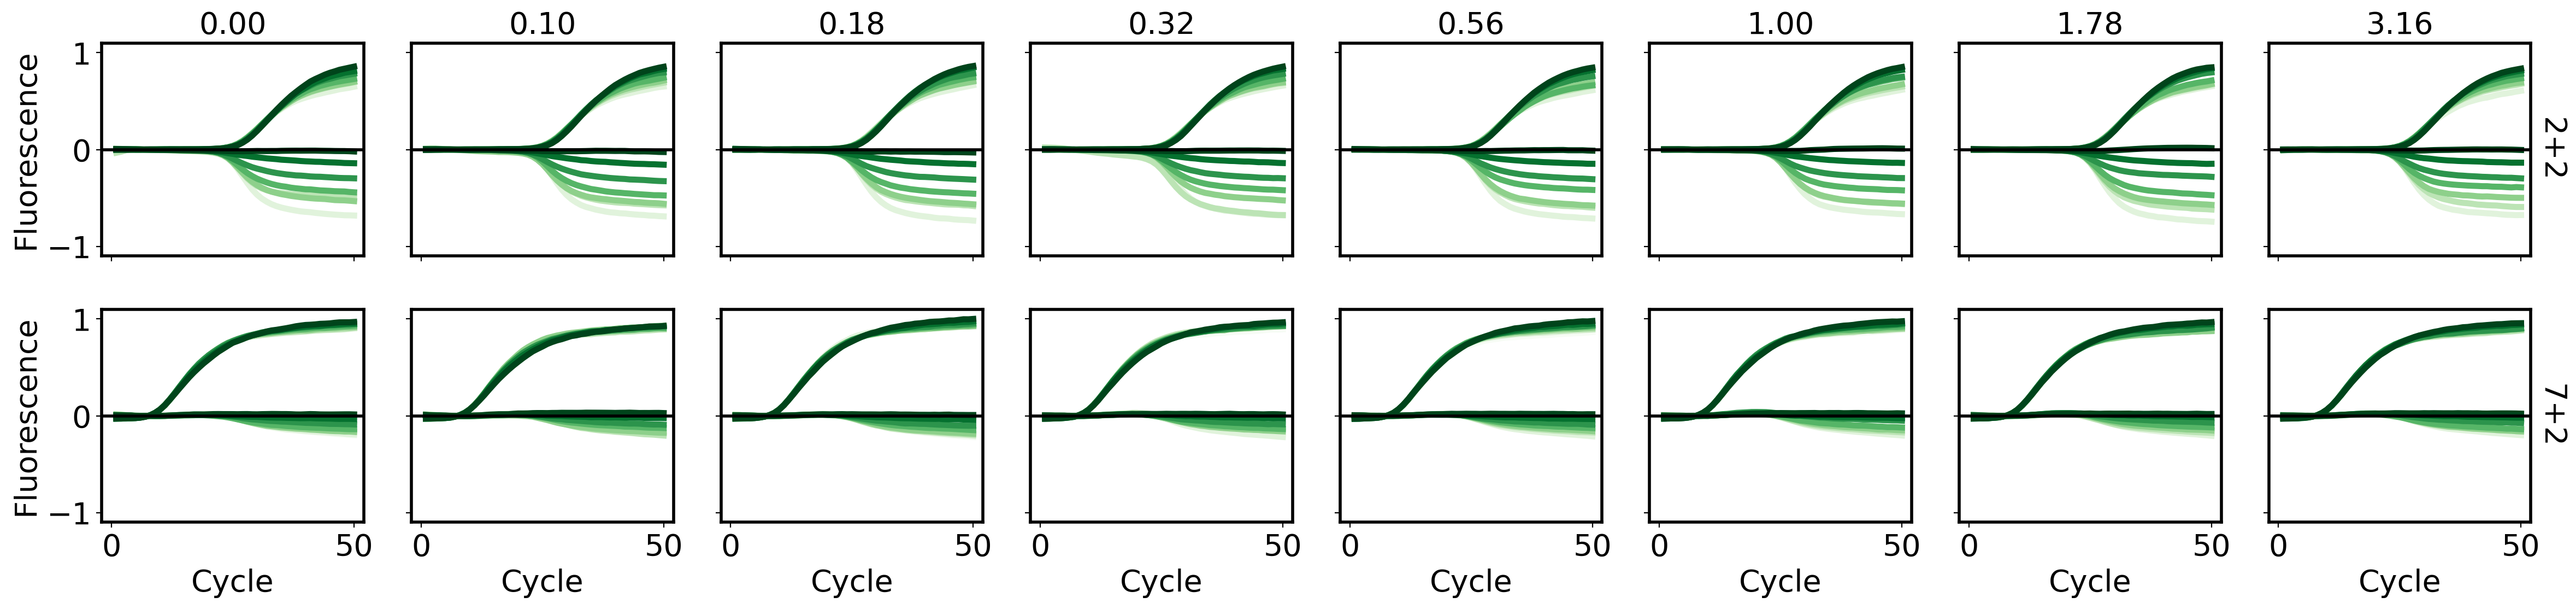

In [6]:
hue = 'lg10_Copies'
extent = np.max(np.abs(JG075B.reactions.wide[hue]))
norm = mpl.colors.Normalize(vmin=JG075B.reactions.wide[hue].min(), vmax=JG075B.reactions.wide[hue].max())

blocker = 'L-MMMMx'
configs = ['2+2','7+2']

for target, palette in target_palette:
    data = JG075B.reactions.data
    data = data[
        (data.Cycle<=cmax) &
#         (data.Configuration==config) &
        (data.Target==target)
    ]

    g = sns.relplot(data = data,
                    x='Cycle', y='Fluorescence', col='Blocker μM', row='Configuration', units='Reaction', hue = hue,
                    legend = False, palette=palette, hue_norm=norm, kind='line', estimator=None, 
                    height=3, aspect=1.0, linewidth=4,
                    facet_kws={
                        'margin_titles': True,
                        'despine': False})

    g.refline(y=0, color='k', linestyle='-')
    g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
    g.set(ylim=[-1.1, 1.1], xlim=[-2, cmax+2])
    # g.set_titles(col_template="", row_template="")
    plt.tight_layout();



In [7]:
ds = gmb.DataSet(JG075B.endpoints, outputs=['SignalDifference'])
gp = gmb.GP(ds).fit(continuous_dims = ['lg10_Copies', 'Blocker μM'],
                    categorical_dims=['Configuration', 'Target'])

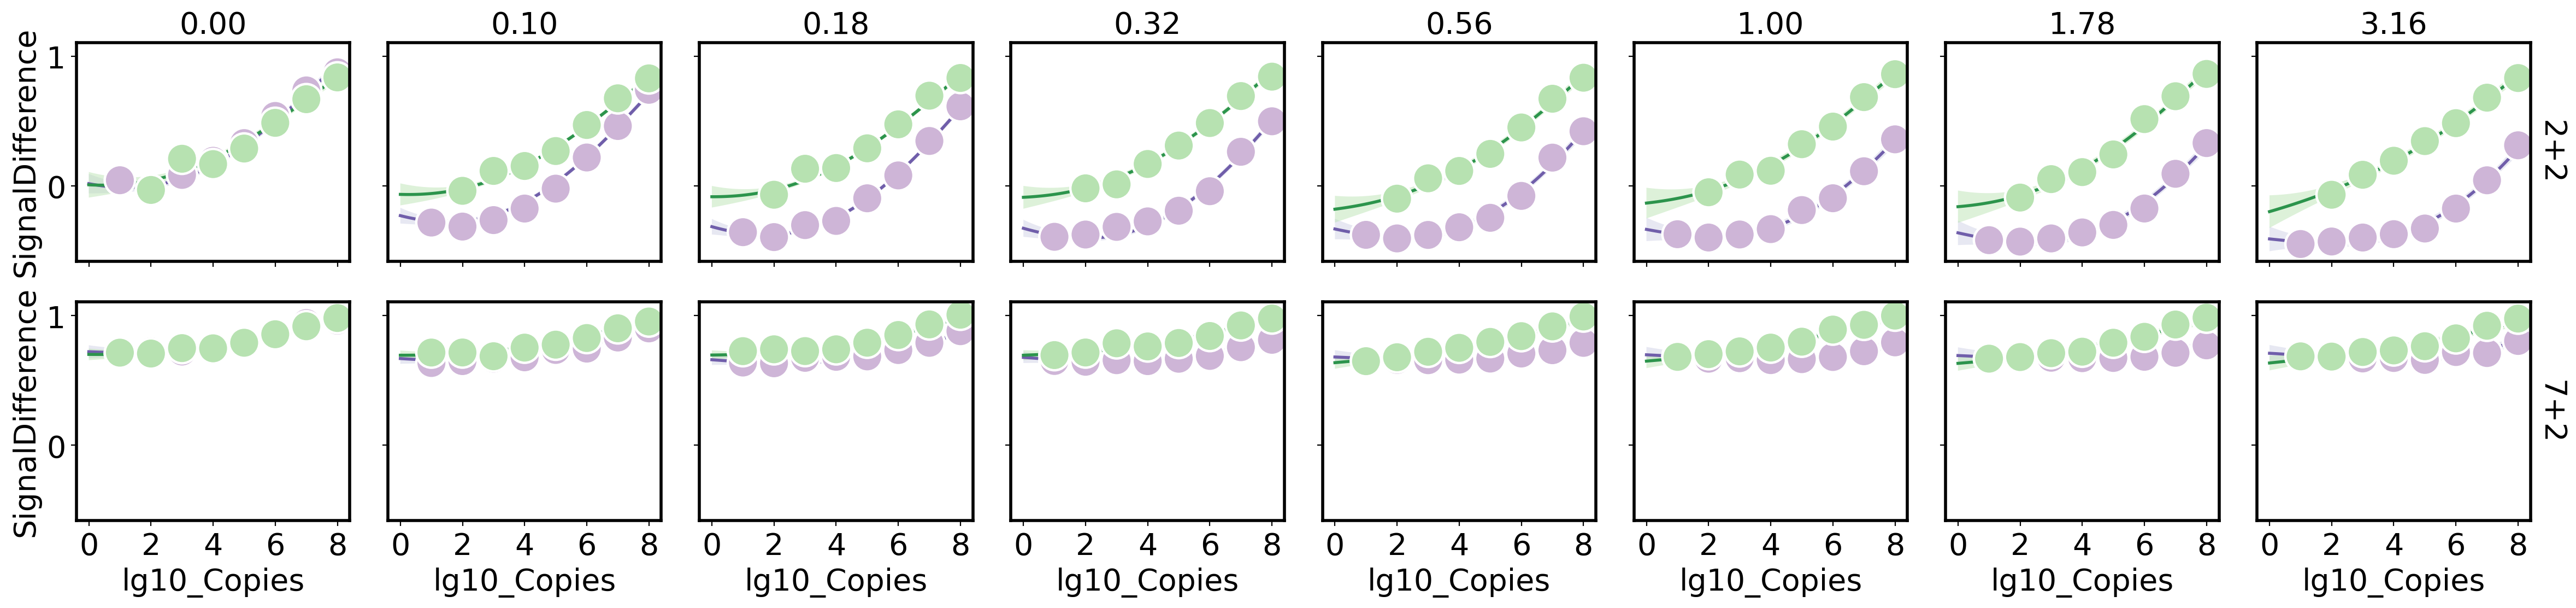

In [8]:
hue = 'SignalDifference'
extent = np.max(np.abs(endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-extent, vmax=+extent)

g = sns.relplot(data = endpoints,
                x='lg10_Copies', y='SignalDifference', 
                col='Blocker μM', row='Configuration',
                hue = 'Target', legend = False, palette='PRGn',
                kind='scatter', height=3, aspect=1.0, s=20**2,
                facet_kws={
                    'margin_titles': True,
                    'despine': False})

# g.refline(y=0, color='k', linestyle=':', zorder=-11)
g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
g.set(xticks=[0, 2, 4, 6, 8])

for (row_val, col_val), ax in g.axes_dict.items():
    
    at = gp.parray(**{'Blocker μM': col_val})
    limits = gp.parray(lg10_Copies=[0,8])
    X = gp.prepare_grid(at=at, limits=limits)['lg10_Copies']
    WT_sig = gp.predict_grid(categorical_levels={'Target': 'S075_WT', 'Configuration': row_val}, with_noise=False)
    SNV_sig = gp.predict_grid(categorical_levels={'Target': 'S075_SNV', 'Configuration': row_val}, with_noise=False)
    
    plt.sca(ax)
    gmb.ParrayPlotter(x=X, y=WT_sig).plot(palette='Purples')
    gmb.ParrayPlotter(x=X, y=SNV_sig).plot(palette='Greens')
    
# g.set(ylabel='')
    
# fig = plt.gcf()
# multicolor_ylabel(fig,('WT Signal',' | ','SNV ΔCT',' | ','ΔΔCT'),('purple','k','green','k','k'), axis='y', ybbox=(0, 0.2))
    
plt.tight_layout();


Saving Fig_ED1_C_ii in /home/john/projects/CAN_paper/fig_ed1/graphics: [.svg] [.png] done
Saving Fig_ED1_C_i in /home/john/projects/CAN_paper/fig_ed1/graphics: [.svg] [.png] done


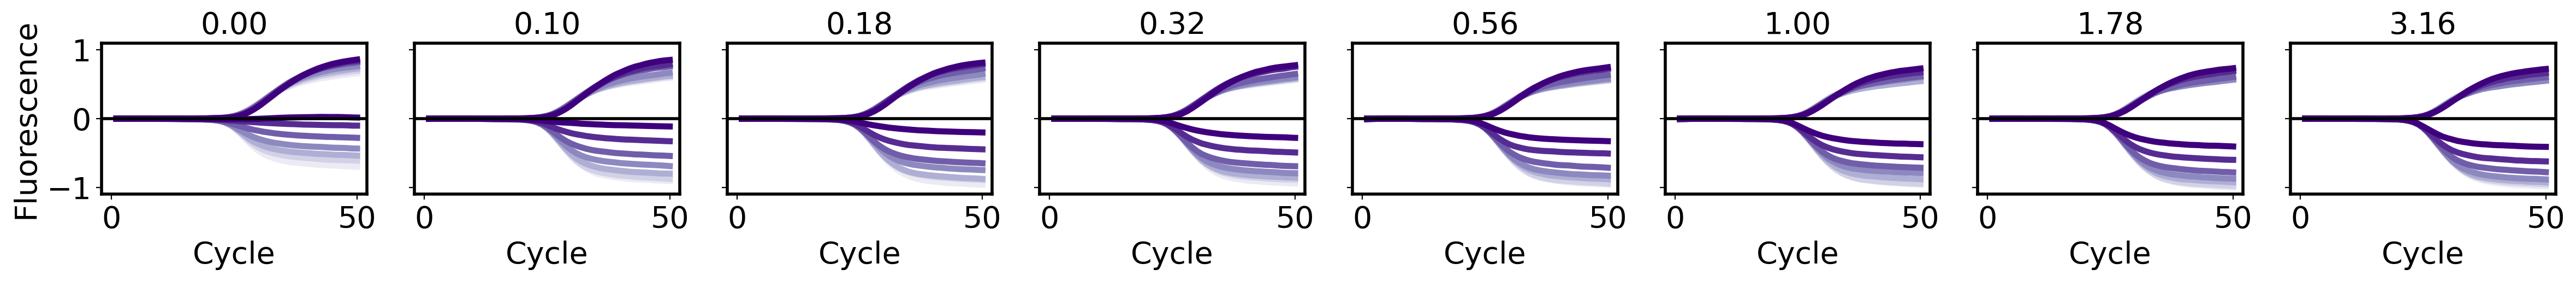

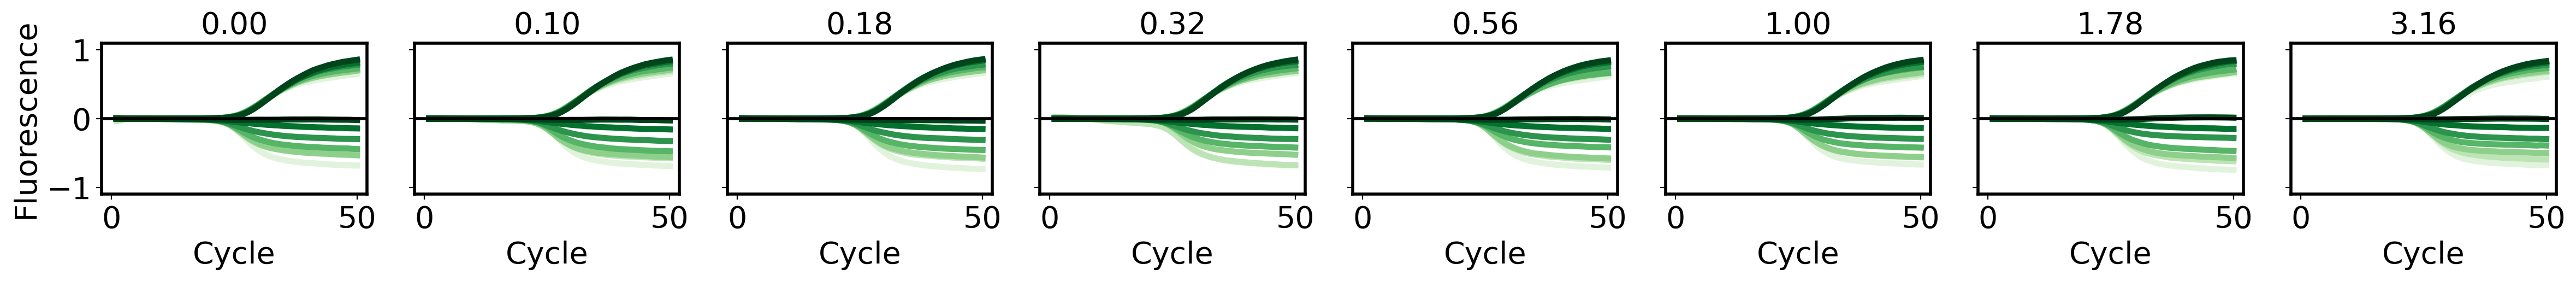

In [10]:
from matplotlib.pyplot import subplot


hue = 'lg10_Copies'
extent = np.max(np.abs(JG075B.reactions.wide[hue]))
norm = mpl.colors.Normalize(vmin=JG075B.reactions.wide[hue].min(), vmax=JG075B.reactions.wide[hue].max())

blocker = 'L-MMMMx'
configs = ['2+2','7+2']

config = '2+2'

for target, palette in target_palette:
    data = JG075B.reactions.data
    data = data[
        (data.Cycle<=cmax) &
        (data.Configuration==config) &
        (data.Target==target)
    ]

    g = sns.relplot(data = data,
                    x='Cycle', y='Fluorescence', col='Blocker μM', units='Reaction', hue = hue,
                    legend = False, palette=palette, hue_norm=norm, kind='line', estimator=None, 
                    height=3, aspect=1.0, linewidth=4,
                    facet_kws={
                        'margin_titles': True,
                        'despine': False})

    g.refline(y=0, color='k', linestyle='-')
    g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
    g.set(ylim=[-1.1, 1.1], xlim=[-2, cmax+2])
    # g.set_titles(col_template="", row_template="")
    plt.tight_layout();
    
    panel = 'C'
    subpanel = {'S075_WT':'ii','S075_SNV':'i'}[target]
    
    savefig()

Saving Fig_ED1_D_i in /home/john/projects/CAN_paper/fig_ed1/graphics: [.svg] [.png] done


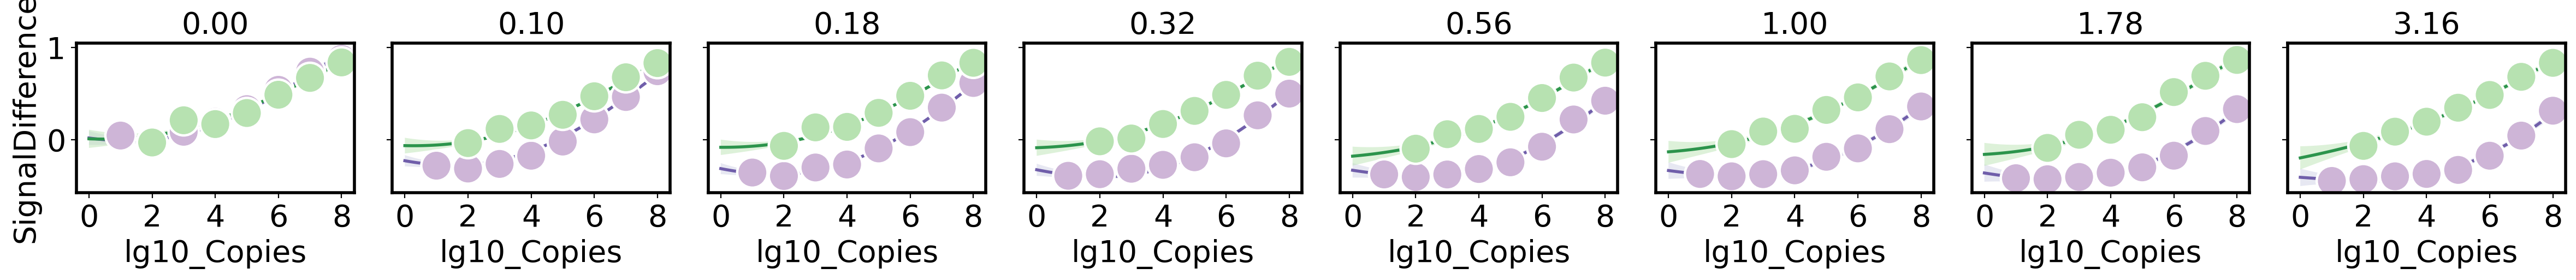

In [11]:
hue = 'SignalDifference'
extent = np.max(np.abs(endpoints[hue]))
norm = mpl.colors.Normalize(vmin=-extent, vmax=+extent)

g = sns.relplot(data = endpoints[endpoints.Configuration==config],
                x='lg10_Copies', y='SignalDifference', 
                col='Blocker μM', #row='Configuration',
                hue = 'Target', legend = False, palette='PRGn',
                kind='scatter', height=3, aspect=1.0, s=20**2,
                facet_kws={
                    'margin_titles': True,
                    'despine': False})

# g.refline(y=0, color='k', linestyle=':', zorder=-11)
g.set_titles(col_template="{col_name:.2f}", row_template="{row_name}")
g.set(xticks=[0, 2, 4, 6, 8])

for (col_val), ax in g.axes_dict.items():
    
    at = gp.parray(**{'Blocker μM': col_val})
    limits = gp.parray(lg10_Copies=[0,8])
    X = gp.prepare_grid(at=at, limits=limits)['lg10_Copies']
    WT_sig = gp.predict_grid(categorical_levels={'Target': 'S075_WT', 'Configuration': '2+2'}, with_noise=False)
    SNV_sig = gp.predict_grid(categorical_levels={'Target': 'S075_SNV', 'Configuration': '2+2'}, with_noise=False)
    
    plt.sca(ax)
    gmb.ParrayPlotter(x=X, y=WT_sig).plot(palette='Purples')
    gmb.ParrayPlotter(x=X, y=SNV_sig).plot(palette='Greens')
    
# g.set(ylabel='')
    
# fig = plt.gcf()
# multicolor_ylabel(fig,('WT Signal',' | ','SNV ΔCT',' | ','ΔΔCT'),('purple','k','green','k','k'), axis='y', ybbox=(0, 0.2))
    
plt.tight_layout();
 
panel = 'D'
savefig()